numpy : Numpy is used to perform wide variety of mathematical operations on arrays.

TensorFlow: It provides a collection of workflows to develop and train models using Python.TensorFlow is mainly used for: Classification, Perception, Understanding, Discovering, Prediction and Creation. 

Matplotlib. pyplot: It is a collection of functions that make matplotlib.It is a library for data visualization, typically in the form of plots, graphs and charts.

Platform: The Platform module is used to retrieve as much possible information about the platform on which the program is being currently executed. Python defines an in-built module platform that provides system information.

TensorFlow Datasets:It is a collection of datasets ready to use, with TensorFlow,All datasets are exposed as tf. data. Datasets , enabling easy-to-use and high-performance input pipelines.

TIme: The Python time module provides many ways of representing time in code, such as objects, numbers,strings and also provides functionality other than representing time, like waiting during code execution and measuring the efficiency of your code.









In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import platform
import time
import pathlib
import os

Downloaded the data

DATASET_NAME

In [ ]:
# Loading the wikipedia dataset.
DATASET_NAME = 'wikipedia/20190301.en'
# DATASET_NAME = 'wikipedia/20190301.uk'

dataset, dataset_info = tfds.load(
    name=DATASET_NAME,
    data_dir='tmp',
    with_info=True,
    split=tfds.Split.TRAIN,
)

Total number of articles in it

In [ ]:
TRAIN_NUM_EXAMPLES = dataset_info.splits['train'].num_examples
print('Total number of articles: ', TRAIN_NUM_EXAMPLES)

Total number of articles:  5824596


Read the data

Take 500 characters in text

In [ ]:
text=""
for example in dataset.take(500):
  text+=example['text'].numpy().decode(encoding='utf-8')
text[:1000]

'Joseph Harold Greenberg (May 28, 1915 – May 7, 2001) was an American linguist, known mainly for his work concerning linguistic typology and the genetic classification of languages.\n\nLife\n\nEarly life and education \n(Main source: Croft 2003)\n\nJoseph Greenberg was born on May 28, 1915 to Jewish parents in Brooklyn, New York. His first great interest was music. At the age of 14, he gave a piano concert in Steinway Hall. He continued to play the piano frequently throughout his life.\n\nAfter finishing high school, he decided to pursue a scholarly career rather than a musical one. He enrolled at Columbia University in New York. During his senior year, he attended a class taught by Franz Boas concerning American Indian languages. With references from Boas and Ruth Benedict, he was accepted as a graduate student by Melville J. Herskovits at Northwestern University in Chicago. During the course of his graduate studies, Greenberg did fieldwork among the Hausa people of Nigeria, where he 


Length of the text

In [ ]:
len(text)

1422915

Here, We used vocabulary where Variable is a way of storing values into the memory of the computer by using specific names that you define.
Printed the number of unique characters in the file.

In [ ]:
vocab = sorted(set(text))
print ('{} unique characters'.format(len(vocab)))

396 unique characters


Process the text

Vectorize the text

Before training, we need to map strings to a numerical representation. Create two lookup tables: one mapping characters to numbers, and another for numbers to characters.

In [ ]:
# Creating a mapping from unique characters to indices
char2idx = {u:i for i, u in enumerate(vocab)}
idx2char = np.array(vocab)

text_as_int = np.array([char2idx[c] for c in text])

Sequence Length is the length of the sequence of input data. 

Here, we're training the model to perform. The input to the model will be a sequence of characters, and we train the model to predict the output—the following character at each time step.

Create training examples and targets

Next divide the text into example sequences. From the text Each input sequence will contain seq_length characters.

For each input sequence, the corresponding targets contain the same length of text, except shifted one character to the right.

So the text is divided into chunks of seq_length+1. 

For example, say seq_length is 4 and our text is "Hello". The input sequence would be "Hell", and the target sequence "ello".


In [ ]:
# The maximum length sentence we want for a single input in characters
seq_length = 100
examples_per_epoch = len(text)//(seq_length+1)
# Create training examples / targets
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)
for i in char_dataset.take(5):
  print(idx2char[i.numpy()])

J
o
s
e
p


By using batch method we converted these individual characters to sequences of the desired size.

In [ ]:
sequences = char_dataset.batch(seq_length+1, drop_remainder=True)

for item in sequences.take(5):
  print(repr(''.join(idx2char[item.numpy()])))

'Joseph Harold Greenberg (May 28, 1915 – May 7, 2001) was an American linguist, known mainly for his w'
'ork concerning linguistic typology and the genetic classification of languages.\n\nLife\n\nEarly life and'
' education \n(Main source: Croft 2003)\n\nJoseph Greenberg was born on May 28, 1915 to Jewish parents in'
' Brooklyn, New York. His first great interest was music. At the age of 14, he gave a piano concert in'
' Steinway Hall. He continued to play the piano frequently throughout his life.\n\nAfter finishing high '


Map method is applied to a simple function to each batch for duplicate and shift it to form the input and target text for each sentence.

In [ ]:
def split_input_target(chunk):
  input_text = chunk[:-1]
  target_text = chunk[1:]
  return input_text, target_text
dataset = sequences.map(split_input_target)

Print Input data and Target data

In [ ]:
for input_example, target_example in  dataset.take(1):
  print ('Input data: ', repr(''.join(idx2char[input_example.numpy()])))
  print ('Target data:', repr(''.join(idx2char[target_example.numpy()])))

Input data:  'Joseph Harold Greenberg (May 28, 1915 – May 7, 2001) was an American linguist, known mainly for his '
Target data: 'oseph Harold Greenberg (May 28, 1915 – May 7, 2001) was an American linguist, known mainly for his w'


Batch_Size: as usual is the number of “concurrent items” you're going to feed into the model.

Buffer_Size: It tells how much data can be held at a time until it is used.

Prefitch_Size: It dictates how many messages will be held in RAM on the client.

We created training batches, before that we shuffled the data and packed it into batches.


In [ ]:
BATCH_SIZE = 64
BUFFER_SIZE = 100
PREFETCH_SIZE = 10
dataset=dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True).prefetch(PREFETCH_SIZE)
dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(64, 100), dtype=tf.int64, name=None), TensorSpec(shape=(64, 100), dtype=tf.int64, name=None))>

For defining the model we used tf.keras.Sequential

Here, we used three Layers

tf.keras.layers.Dense: The output layer, with vocab_size outputs.

tf.keras.layers.Embedding: The input layer. A trainable lookup table that will map the numbers of each character to a vector with embedding_dim dimensions;

tf.keras.layers.GRU: A type of RNN with size units=rnn_units (You can also use a LSTM layer here.)


In [ ]:
vocab_size = len(vocab)
embedding_dim = 256
rnn_units = 1024

In [ ]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Embedding(
      input_dim=vocab_size,
      output_dim=embedding_dim,
      batch_input_shape=[batch_size, None]
    ))
    model.add(tf.keras.layers.LSTM(
      units=rnn_units,
      return_sequences=True,
      stateful=True,
      recurrent_initializer=tf.keras.initializers.GlorotNormal()
    ))
    model.add(tf.keras.layers.Dense(vocab_size))
    return model

In [ ]:
model = build_model(vocab_size, embedding_dim, rnn_units, BATCH_SIZE)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (64, None, 256)           101376    
                                                                 
 lstm (LSTM)                 (64, None, 1024)          5246976   
                                                                 
 dense (Dense)               (64, None, 396)           405900    
                                                                 
Total params: 5,754,252
Trainable params: 5,754,252
Non-trainable params: 0
_________________________________________________________________


Used tf.keras.utils.plot_model,It allowed to create a visualization of our Keras neural network.



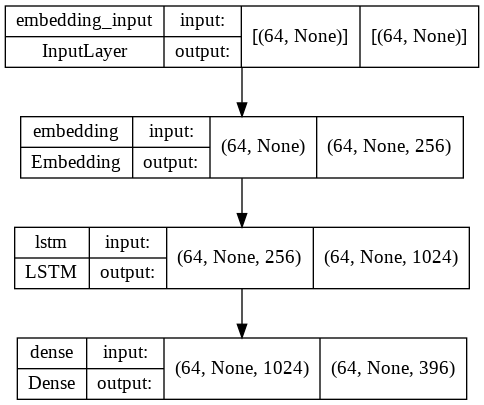

In [ ]:
tf.keras.utils.plot_model(model,show_shapes=True,show_layer_names=True,)

Try the model

Now run the model to see that it behaves as expected.

First check the shape of the output:

In [ ]:
for input_example_batch, target_example_batch in dataset.take(1):
  example_batch_predictions = model(input_example_batch)
  print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 100, 396) # (batch_size, sequence_length, vocab_size)


tf.random categorical: It is used to create a random seed for the distribution. See tf. random. behaviour.

tf. squeeze() function returns a tensor with the same value as its first argument, but a different shape.

In [ ]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices,axis=-1).numpy()
sampled_indices

array([ 15, 242, 223, 309,  95,   0, 347, 345, 298,  68, 292, 166, 243,
       286,  20, 121, 315, 193, 375, 117, 261,  68, 300, 342,  46,  66,
       196,  43, 297, 197, 122, 359, 309, 141, 153, 154, 387, 229, 312,
       124,  42, 307, 197,  10, 170, 269, 130, 164, 242, 102, 165, 332,
        12, 163, 317, 177, 266,  26, 383,  61, 274, 164,  72, 225, 168,
       352, 365,  23, 300,   8,  71,  64, 348, 146, 320, 237, 214,   7,
       136,  49,  28, 270, 366, 220, 379, 275, 244, 259, 245, 125,   6,
       156, 318, 128, 326,  29, 332, 148, 277, 346])

Attach an optimizer, and a loss function The standard tf.keras.losses.sparse_categorical_crossentropy loss function works in this case because it is applied across the last dimension of the predictions.

Print Prediction shape and Scalar_loss

In [ ]:
def loss(labels, logits):
  return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

example_batch_loss  = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("scalar_loss:      ", example_batch_loss.numpy().mean())

Prediction shape:  (64, 100, 396)  # (batch_size, sequence_length, vocab_size)
scalar_loss:       5.981655


Adam Optimizer: It is used to accelerate the gradient descent algorithm by taking into consideration the 'exponentially weighted average' of the gradients with default arguments and the loss function.

In [ ]:
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=adam_optimizer,loss=loss)

The checkpoint may be used directly, or used as the starting point for a new run, picking up where it left off.

ModelCheckpoint callback is used in conjunction with training using model.the callback supports saving at the end of every epoch, or after a fixed number of training batches.

In [ ]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

To train the model we are using 50 epochs to keep training and also we used  10 steps_per_epoch.

In [ ]:
EPOCHS=50
STEPS_PER_EPOCH = 10
tmp_dataset = dataset.repeat()
history = model.fit(x=tmp_dataset.as_numpy_iterator(),epochs=EPOCHS,steps_per_epoch=STEPS_PER_EPOCH,callbacks=[checkpoint_callback])

Epoch 1/50
10/10 [==============================] - 81s 8s/step - loss: 2.4058
Epoch 2/50
10/10 [==============================] - 83s 8s/step - loss: 2.3382
Epoch 3/50
10/10 [==============================] - 80s 8s/step - loss: 2.3685
Epoch 4/50
10/10 [==============================] - 77s 8s/step - loss: 2.3459
Epoch 5/50
10/10 [==============================] - 81s 8s/step - loss: 2.3368
Epoch 6/50
10/10 [==============================] - 82s 8s/step - loss: 2.2597
Epoch 7/50
10/10 [==============================] - 82s 8s/step - loss: 2.2987
Epoch 8/50
10/10 [==============================] - 85s 8s/step - loss: 2.3355
Epoch 9/50
10/10 [==============================] - 81s 8s/step - loss: 2.3107
Epoch 10/50
10/10 [==============================] - 79s 8s/step - loss: 2.1904
Epoch 11/50
10/10 [==============================] - 80s 8s/step - loss: 2.2733
Epoch 12/50
10/10 [==============================] - 82s 8s/step - loss: 2.2426
Epoch 13/50
10/10 [==============================

Using a Keras Long Short-Term Memory (LSTM) Model to Predict Stock Prices.It is a variation of a recurrent neural network (RNN) that is quite effective in predicting the long sequences of data like sentences and stock prices over a period of time.

RNN layer uses a for loop to iterate over the timesteps of a sequence, while maintaining an internal state that encodes information about the timesteps it has seen so far. 

Embedding layer: It enables us to convert each word into a fixed length vector of defined size.

Dense Layer: It is a normal fully connected layer in a neuronal network.It is used to classify image based on output from convolutional layers.

In [ ]:
tf.train.latest_checkpoint(checkpoint_dir)
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
model.build(tf.TensorShape([1, None]))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (1, None, 256)            101376    
                                                                 
 lstm_1 (LSTM)               (1, None, 1024)           5246976   
                                                                 
 dense_1 (Dense)             (1, None, 396)            405900    
                                                                 
Total params: 5,754,252
Trainable params: 5,754,252
Non-trainable params: 0
_________________________________________________________________


Number of characters are generated then converted our start string to numbers.
we used temperature=0.4 to get results in most predictable text.
Categorical distribution is used to predict the character.
Here,predicted character passed as the next input to the modelalong with the previous hidden state.

In [ ]:
def generate_text(model, start_string):
  num_generate = 1000
  input_eval = [char2idx[s] for s in start_string]
  input_eval = tf.expand_dims(input_eval, 0)
  text_generated = []
  temperature = 0.4
  model.reset_states()
  for i in range(num_generate):
    predictions = model(input_eval)
    predictions = tf.squeeze(predictions, 0)
    predictions = predictions / temperature
    predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()
    input_eval = tf.expand_dims([predicted_id], 0)
    text_generated.append(idx2char[predicted_id])
  return (start_string + ''.join(text_generated))

Print the text

In [ ]:
print(generate_text(model, start_string=u"Science is"))

Science is a site and the south School, and the tour the American states the tour the served be the served in the secords in the earned and the eards in the more of the played the early been the for a distory of the fings of the consident with streated to the prose to a support the finst with the countion of the soured the films the consident of the bound reague in the sears and the sure and are an into the including the exter to count to the ore in the bling and the for the previnal contrict of the sup to the signed the seated the served of the and the Right of the Roge was betan a sillers in the eard with the stering the support of the singer the tour the season of the town as the strough and the furst the the feature the served to the south of the served and the searsher to the contround and the light the was esting the east in the are and the propection of the strand been enting the site of the served the and the seave the town and a specied in the controduction of the in the contr